#### Machine Learning

**Random Forest**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
df_airlines = pd.read_csv('../data/ontime_2025.csv')
df_airlines.head(5)

,year,month,day_of_month,day_of_week,op_unique_carrier,op_carrier_airline_id,op_carrier_fl_num,origin,origin_city_name,origin_state_abr,...,carrier_delay,weather_delay,nas_delay,security_delay,dep_time_dt,arr_time_dt,dep_bin,season,delay_category,fl_date
0,2024,11,1,5,9E,20363,4800,CLT,"Charlotte, NC",NC,...,6.0,0.0,0.0,0.0,1900-01-01 18:28:00,1900-01-01 20:15:00,Early Evening,Autumn,Moderate Delay,2024-11-01
1,2024,11,1,5,9E,20363,4801,CVG,"Cincinnati, OH",KY,...,0.0,0.0,0.0,0.0,1900-01-01 17:41:00,1900-01-01 18:49:00,Afternoon,Autumn,On Time,2024-11-01
2,2024,11,1,5,9E,20363,4802,DSM,"Des Moines, IA",IA,...,0.0,0.0,0.0,0.0,1900-01-01 15:54:00,1900-01-01 16:57:00,Afternoon,Autumn,On Time,2024-11-01
3,2024,11,1,5,9E,20363,4803,CVG,"Cincinnati, OH",KY,...,0.0,0.0,0.0,0.0,1900-01-01 13:50:00,1900-01-01 14:55:00,Midday,Autumn,On Time,2024-11-01
4,2024,11,1,5,9E,20363,4804,GSP,"Greer, SC",SC,...,0.0,0.0,0.0,0.0,1900-01-01 12:45:00,1900-01-01 14:35:00,Midday,Autumn,On Time,2024-11-01


In [3]:
df_airlines['is_delayed'] = df_airlines['dep_del15']

In [6]:
airline_df = df_airlines[df_airlines['cancelled'] == 0].copy()


- numeric_features = ['month', 'day_of_month', 'day_of_week']

- categorical_features = [
    'dep_bin',
    'season',
    'origin',
    'dest',
    'op_unique_carrier'
]


In [7]:
df_ml = airline_df.sample(n = 100000, replace = False, random_state = 42)

In [8]:
df_ml_numeric = df_ml[['month', 'day_of_month', 'day_of_week']]

df_ml_cat = df_ml[
    [
        'dep_bin',
        'season',
        'origin',
        'dest',
        'op_unique_carrier'
    ]
]

*Scale*

In [9]:
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, df_ml_numeric.columns)
    ]
)

ml_numeric_scaled = preprocessor.fit_transform(df_ml_numeric)

df_ml_numeric_scaled = pd.DataFrame(
    ml_numeric_scaled,
    columns=df_ml_numeric.columns,
    index=df_ml_numeric.index
)

In [10]:
df_ml_numeric_scaled

,month,day_of_month,day_of_week
4169733,-0.177786,-0.761350,-1.494072
1309675,-1.652308,-0.875025,-0.500019
182431,1.296736,-0.647676,1.488087
510126,1.296736,1.284792,-0.500019
3385100,-0.767595,1.625816,-0.500019
...,...,...,...
420784,1.296736,0.716419,0.494034
3346613,-0.767595,1.398467,-1.494072
5006778,0.117118,0.489070,1.488087
5675870,0.412023,0.716419,0.494034


In [11]:
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, df_ml_cat.columns)
    ]
)

ml_cat_scaled = preprocessor.fit_transform(df_ml_cat)

feature_names = preprocessor.get_feature_names_out()

df_ml_cat_scaled = pd.DataFrame(
    ml_cat_scaled.toarray() if hasattr(ml_cat_scaled, "toarray") else ml_cat_scaled,
    columns=feature_names,
    index=df_ml_cat.index
)

In [12]:
df_ml_concat = pd.concat([df_ml_numeric_scaled, df_ml_cat_scaled], axis=1)

In [13]:
X = df_ml_concat
y = df_ml['is_delayed']

#### Random Forest

*Split into Training and Testing sets*

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

rf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(
        n_estimators=20,
        max_depth=6,
        min_samples_leaf=500,
        n_jobs=-1,
        random_state=42
    ))
])

*Fit the model*

In [16]:
rf.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",20
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",6
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2


In [17]:
X_train

,month,day_of_month,day_of_week,cat__dep_bin_Early Evening,cat__dep_bin_Early Morning,cat__dep_bin_Late Morning,cat__dep_bin_Late Night,cat__dep_bin_Midday,cat__dep_bin_Night,cat__dep_bin_nan,...,cat__op_unique_carrier_F9,cat__op_unique_carrier_G4,cat__op_unique_carrier_HA,cat__op_unique_carrier_MQ,cat__op_unique_carrier_NK,cat__op_unique_carrier_OH,cat__op_unique_carrier_OO,cat__op_unique_carrier_UA,cat__op_unique_carrier_WN,cat__op_unique_carrier_YX
1763930,-1.357404,-1.329723,-0.997045,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3632046,-0.472691,-0.306652,-0.997045,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
644112,1.591640,-1.329723,-0.500019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4217551,-0.177786,-0.534001,-0.500019,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
645111,1.591640,-1.329723,-0.500019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2234385,-1.062499,-1.557072,1.488087,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6674005,1.001832,-0.192977,-0.997045,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6979049,1.001832,1.625816,-0.002992,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
848002,1.591640,-0.079303,1.488087,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


*Predict and Evaluate*

In [18]:
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88     15865
         1.0       0.00      0.00      0.00      4135

    accuracy                           0.79     20000
   macro avg       0.40      0.50      0.44     20000
weighted avg       0.63      0.79      0.70     20000



/Users/patriciaviladomiurecio/Ironhack/final_project/final_project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/patriciaviladomiurecio/Ironhack/final_project/final_project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/patriciaviladomiurecio/Ironhack/final_project/final_project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

*Visualize the performance*

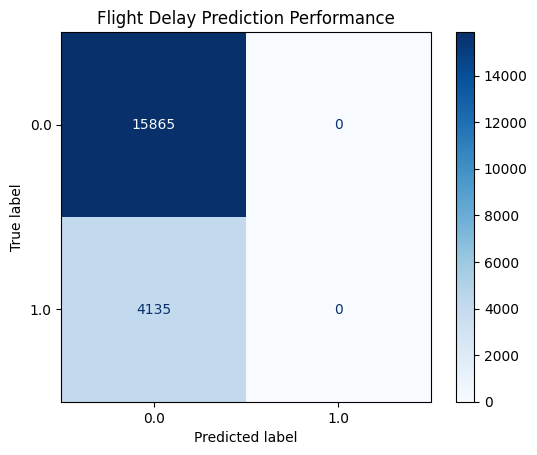

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap='Blues')
plt.title("Flight Delay Prediction Performance")
plt.show()

In [20]:
import joblib

joblib.dump(rf, "rf_model.pkl")

['rf_model.pkl']

#### Oversampling

In [23]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import precision_score, recall_score

over_sampling = RandomOverSampler(random_state=42)
X_over, y_over = over_sampling.fit_resample(X_train, y_train)

rf_over = RandomForestClassifier(n_estimators=20,
        max_depth=6,
        min_samples_leaf=500,
        n_jobs=-1,
        random_state=42).fit(X_over, y_over)
print(f"Oversampling Recall: {recall_score(y_test, rf_over.predict(X_test))}")

Oversampling Recall: 0.6609431680773882


#### Undersampling

In [24]:
from imblearn.under_sampling import RandomUnderSampler

uner_sampling = RandomUnderSampler(random_state=42)
X_under, y_under = uner_sampling.fit_resample(X_train, y_train)

rf_under = RandomForestClassifier(n_estimators=20,
        max_depth=6,
        min_samples_leaf=500,
        n_jobs=-1,
        random_state=42).fit(X_under, y_under)
print(f"Undersampling Recall: {recall_score(y_test, rf_under.predict(X_test))}")

Undersampling Recall: 0.5429262394195888


#### SMOTE

In [25]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

rf_smote = RandomForestClassifier(n_estimators=20,
        max_depth=6,
        min_samples_leaf=500,
        n_jobs=-1,
        random_state=42).fit(X_smote, y_smote)
print(f"SMOTE Recall: {recall_score(y_test, rf_smote.predict(X_test))}")

SMOTE Recall: 0.6244256348246675
